# Graphs for Benzi - Histograms (Density)

In [3]:
from nuscenes.nuscenes import NuScenes
directory = r"/home/kfir/workspace/nuScenes/v1.0-trainval"
nusc = NuScenes(version="v1.0-trainval", dataroot=directory, verbose=False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(1650, 2)
(1650, 2)


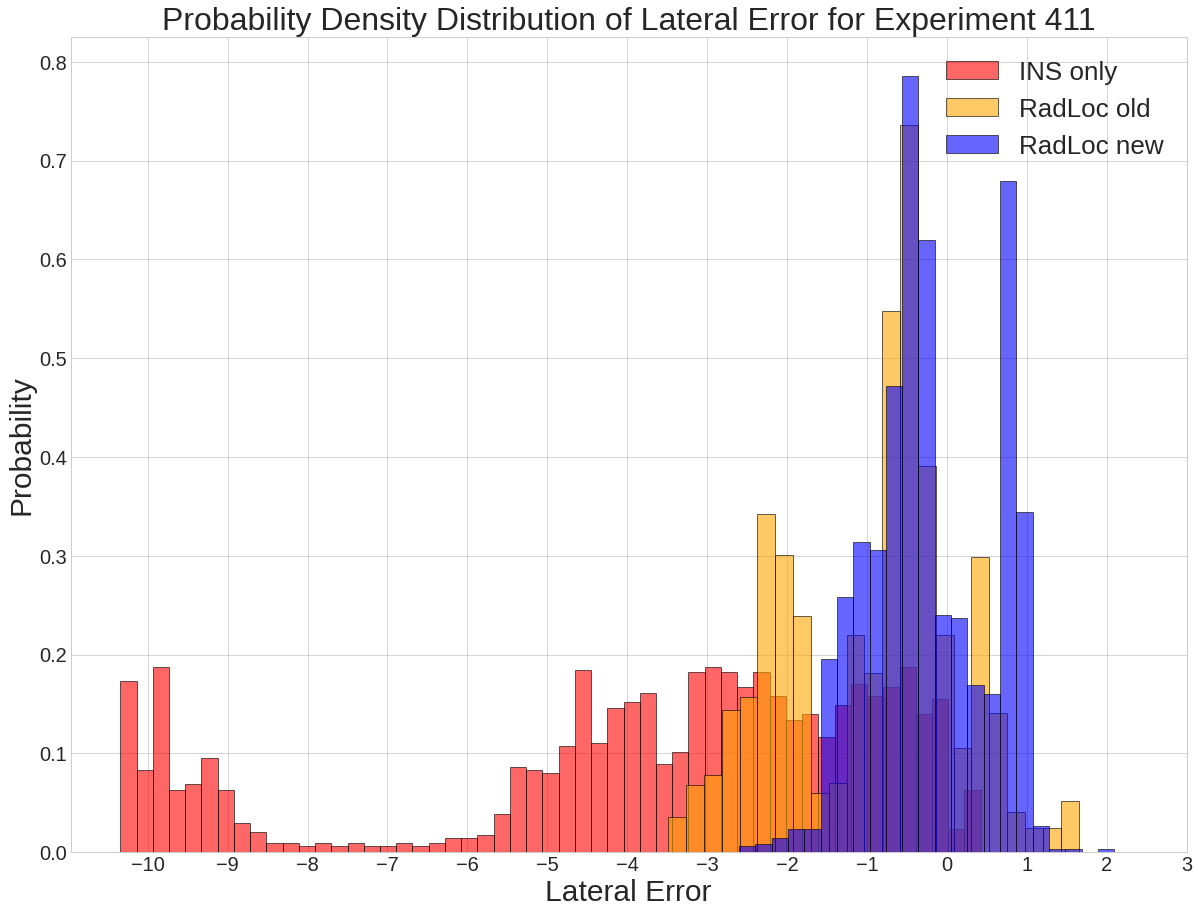

In [43]:
%load_ext autoreload
%autoreload 2
from database import NuscenesProcessedDatabase
import numpy as np
from tqdm import tqdm
from metrics import *
from simulation import NuscenesSimulation
from matplotlib.ticker import MultipleLocator
import matplotlib.pyplot as plt

class DummyModel():
    def __init__(self):
        self.mm = True
"""
scene = 325
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1800, video_list=video_list, save_processed=False)

data_new = NuscenesProcessedDatabase(scene_id=scene, base_dir='images')
data_old = NuscenesProcessedDatabase(scene_id=scene, base_dir='old_images/images_16_7_23')
"""
nusc_map = sim.dataset.nusc_map
video_with_priors = True

#frames = range(1,900) #426
#frames = range(1,1120) #365
#frames = range(1,1650) #325
#frames = range(1,1200) #494
#frames = range(1,1600) #690
#frames = range(1,1600) #814

N = 1650
error_vector_new, imu_error_vector = getLatErrors(sim, data_new, N)
error_vector_old, _ = getLatErrors(sim, data_old, N)

# Calculate the bin size based on the range of errors
bin_size = 0.2  # Set your desired bin size

# Calculate the number of bins based on the bin size and range of errors
num_bins = int((max(error_vector_new) - min(error_vector_new)) / bin_size)
imu_num_bins = int((max(imu_error_vector) - min(imu_error_vector)) / bin_size)

# Create a figure and axis
fig, ax = plt.subplots(1,1,figsize=(20,15))

# Create the normalized histogram on the axis

ax.hist(imu_error_vector, bins=imu_num_bins, edgecolor='black', alpha=0.6, density=True, stacked=True, label='INS only',color='r')
ax.hist(error_vector_old, bins=num_bins, edgecolor='black', alpha=0.6, density=True, stacked=True, label='RadLoc old',color='orange')
ax.hist(error_vector_new, bins=num_bins, edgecolor='black', alpha=0.6, density=True, stacked=True, label='RadLoc new',color='blue')

# Add labels and title
ax.set_xlabel('Lateral Error', fontsize=30)
ax.set_ylabel('Probability', fontsize=30)
ax.set_title('Probability Density Distribution of Lateral Error for Experiment 411', fontsize=32)
ax.legend(prop={'size': 26})
ax.set_xticks(np.linspace(int(min(imu_error_vector)), int(max(error_vector_new))+1, 20))
ax.xaxis.set_major_locator(MultipleLocator(base=1))
ax.tick_params(axis='x', labelsize=20) 
ax.tick_params(axis='y', labelsize=20) 

In [42]:
def getLatErrors(sim, data, N):
    video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(0)
    ego_path = sim.dataset.getEgoPath()[:N,0:2]#video_data["ego_path"][0:1800,0:2]
    print(ego_path.shape)
    ego_trns = sim.dataset.ego_trns[:N]#video_data["ego_trns"][0:1800]

    pf_pos = np.zeros((N,2))
    imu_pos = np.zeros((N,2))

    pf_lat_pos = np.zeros(N)
    pf_lon_pos = np.zeros(N)
    imu_lat_pos = np.zeros(N)
    imu_lon_pos = np.zeros(N)
    gt_lat_pos = np.zeros(N)
    gt_lon_pos = np.zeros(N)
    #N = ego_path.shape[0]
    for t in range(0,N):
        if t > 1645 and t < 1651 or t==1088: #325
            continue 
        #if t >= 1190 and t < 1200 or t==1088: #494
        #    continue
        video_data, polynoms, points, dynamic_tracks, dynamic_clusters, mm_results, translation, debug_info = data.load(t)
        pf_pos[t,:] = np.array(mm_results['pf_mean_pos'])
        imu_pos[t,:] = np.array(video_data['pos_imu'][0:2])

        gt_track_pos, pf_track_pos, imu_track_pos = calcTrackPosition(ego_path, ego_trns, ego_path[t, 0:2], pf_pos[t,:], imu_pos[t,:])
        pf_lat_pos[t] = pf_track_pos[0]
        pf_lon_pos[t] = pf_track_pos[1]
        imu_lat_pos[t] = imu_track_pos[0]
        imu_lon_pos[t] = imu_track_pos[1]
        gt_lat_pos[t] = gt_track_pos[0]
        gt_lon_pos[t] = gt_track_pos[1]
        res = pf_lat_pos[t] - gt_lat_pos[t]
        if abs(res) > 3.5:
            pf_lat_pos[t] -= np.sign(res) * 2.5
            continue
        
    error_vector = pf_lat_pos-gt_lat_pos
    imu_error_vector = imu_lat_pos-gt_lat_pos
        
    return error_vector, imu_error_vector

# Error Over Time (For Benzi)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Text(0.5, 0.98, 'Lateral & Longitudinal Errors for Experiment 411')

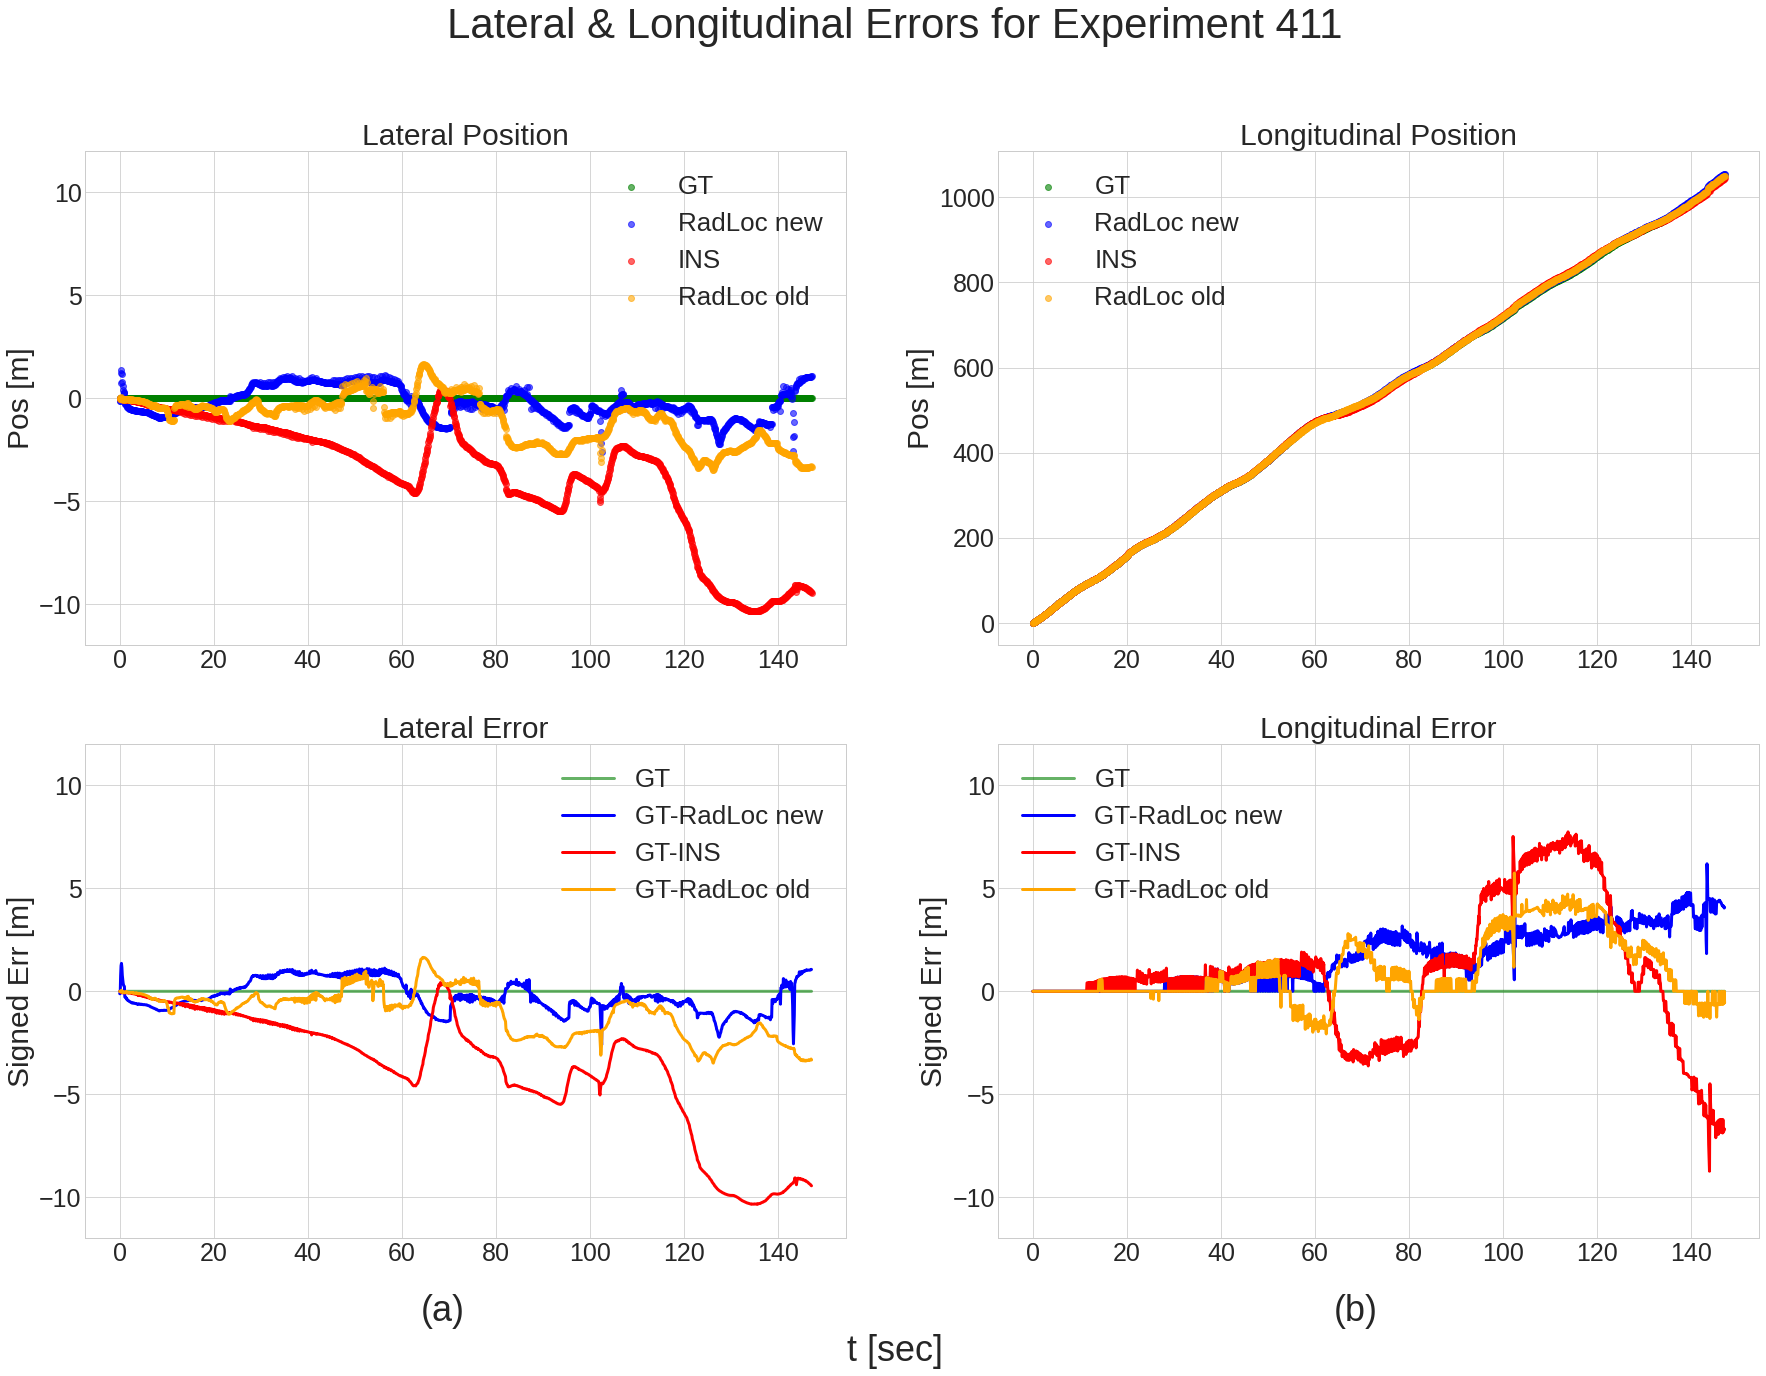

In [78]:
%load_ext autoreload
%autoreload 2
from simulation import NuscenesSimulation
from database import NuscenesProcessedDatabase
from tqdm import tqdm
import matplotlib.pyplot as plt
from plotting import *

class DummyModel():
    def __init__(self):
        self.mm = True
     
"""
scene = 325
dummy_model = DummyModel()
video_list={'video' : False, 'video_debug': False, 'video_pf': False, 'video_pf_xy': False, 'dynamic_tracker': False}
sim = NuscenesSimulation(nusc=nusc, model=dummy_model, scene_id=scene, Nmax=1600, video_list=video_list, save_processed=True)

data_new = NuscenesProcessedDatabase(scene_id=scene)
data_old = NuscenesProcessedDatabase(scene_id=scene, base_dir='old_images/images_16_7_23')
"""
fig, ax = plt.subplots(2,2,figsize=(30,20))
#ax[0,0].axis('equal')
#ax[1,0].axis('equal')
#ax[0,1].axis('equal')
#ax[1,1].axis('equal')

#frames = range(1,900) #426
#frames = range(1,1120) #365
frames = range(1,1650) #325
#frames = range(1,1150) #494
#frames = range(1,1600) #690
#frames = range(1,1600) #814

ax = generateGraphCrossAlong(data_new, frames, ax, label='RadLoc new', color='blue', INS=True, GT=True)
ax = generateGraphCrossAlong(data_old, frames, ax, label='RadLoc old', color='orange', INS=False, GT=False)

ax[0,0].tick_params(axis="x", labelsize=25)
ax[0,0].tick_params(axis="y", labelsize=25)
ax[0,1].tick_params(axis="x", labelsize=25)
ax[0,1].tick_params(axis="y", labelsize=25)
ax[1,0].tick_params(axis="x", labelsize=25)
ax[1,0].tick_params(axis="y", labelsize=25)
ax[1,1].tick_params(axis="x", labelsize=25)
ax[1,1].tick_params(axis="y", labelsize=25)
fig.text(0.5, 0.04, 't [sec]', ha='center', fontsize=36)

#fig.text(0.5, 0.04, 'x [m]', ha='center', fontsize=36)
#fig.text(0.14, 0.5, 'y [m]', va='center', rotation='vertical', fontsize=36)
ax[0,0].legend(loc='upper right',prop={'size': 26})
ax[0,0].legend(prop={'size': 26})
ax[0,0].set_title('Lateral Position', fontsize=30)
ax[0,0].set_ylabel('Pos [m]', fontsize=30)
#ax[0,0].set_ylim(-22,22)
#ax[0,0].set_ylim(-8,8)
ax[0,0].set_ylim(-12,12)
ax[1,0].legend(loc='upper right',prop={'size': 26})
ax[1,0].legend(prop={'size': 26})
ax[1,0].set_title('Lateral Error', fontsize=30)
ax[1,0].set_ylabel('Signed Err [m]', fontsize=30)
#ax[1,0].set_ylim(-22,22)
#ax[1,0].set_ylim(-8,8)
ax[1,0].set_ylim(-12,12)
ax[0,1].legend(loc='upper right',prop={'size': 26})
ax[0,1].legend(prop={'size': 26})
ax[0,1].set_title('Longitudinal Position', fontsize=30)
ax[0,1].set_ylabel('Pos [m]', fontsize=30)
ax[1,1].legend(loc='upper right',prop={'size': 26})
ax[1,1].legend(prop={'size': 26})
ax[1,1].set_title('Longitudinal Error', fontsize=30)
ax[1,1].set_ylabel('Signed Err [m]', fontsize=30)
#ax[1,1].set_ylim(-22,22)
#ax[1,1].set_ylim(-8,8)
ax[1,1].set_ylim(-12,12)
#ax[0,1].set_xlabel('t [sec]', fontsize=28, labelpad=25)
#ax[1].set_ylabel('y [m]', fontsize=28, labelpad=25)
#ax[1,0].text(frames[-1]/24, -28, '(a)', ha='center', fontsize=36)
#ax[1,1].text(frames[-1]/24, -28, '(b)', ha='center', fontsize=36)
ax[1,0].text(frames[-1]/24, -16, '(a)', ha='center', fontsize=36)
ax[1,1].text(frames[-1]/24, -16, '(b)', ha='center', fontsize=36)
fig.suptitle('Lateral & Longitudinal Errors for Experiment 411', fontsize=42)